# Add new analyses to the evaluation

Plot accuracy depending on chosen costs.

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import pickle

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

# Load the evaluation data saved in experiment 20

In [4]:
with open('dataset/nursery/nursery_evaluation.pickle', 'rb') as f:
    data = pickle.load(f)
    
all_contexts, all_rewards = data

In [5]:
all_contexts

,form,children,housing,finance,health
1,1,1,1,1,3
4,1,1,1,1,3
5,1,1,1,1,1
7,1,1,1,1,3
8,1,1,1,1,1
...,...,...,...,...,...
12950,4,4,3,1,1
12951,4,4,3,2,2
12953,4,4,3,2,1
12954,4,4,3,2,2


## DROP for debug

In [6]:
all_contexts = all_contexts.drop(columns=['form', 'children'])

In [7]:
all_rewards

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 0., 1.],
       [0., 0., 1.]])

## Set BETA parameter for the experiment

In [8]:
BETA = 1

# Adding non-stationarity


### Non-stationarity in rewards

In [9]:
all_rewards.shape[0]

10000

In [10]:
stationarity_regions = [
    slice(0, 500),
    slice(500, 1000),
    slice(1000, 2000),
    slice(2000, 3500),
    slice(3500, 5000),
    slice(5000, 6500),
    slice(6500, 8000),
    slice(8000, all_contexts.shape[0]),
]

In [11]:
change_point_values = [x.start for x in stationarity_regions] + [stationarity_regions[-1].stop]
change_point_values[0] += 1

In [12]:
change_point_values

[1, 500, 1000, 2000, 3500, 5000, 6500, 8000, 10000]

In [13]:
# We invert arm 0 with 2 and 1 with 3 (
np.mean(all_rewards, axis=0)

array([0.3405, 0.3372, 0.3223])

In [14]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.zeros(new_rewards.shape)

n_arms = all_rewards.shape[1]

for i, region in enumerate(stationarity_regions):
    for arm_from in range(n_arms):
        # Cyclic shift of class labels
        arm_to = (arm_from + i) % n_arms
        if i > 0:
            new_rewards[region, arm_to] = all_rewards[region, arm_from]
        
        # For plotting
        mean_rewards[region, arm_to] = (
            np.ones(new_rewards[region, arm_to].shape) * np.mean(new_rewards[region, arm_to])
        )

In [15]:
new_contexts.shape, new_rewards.shape

((10000, 3), (10000, 3))

## Plot expected reward

Min expected reward for arm 1: 0.0
Min expected reward for arm 2: 0.023
Min expected reward for arm 3: 0.0


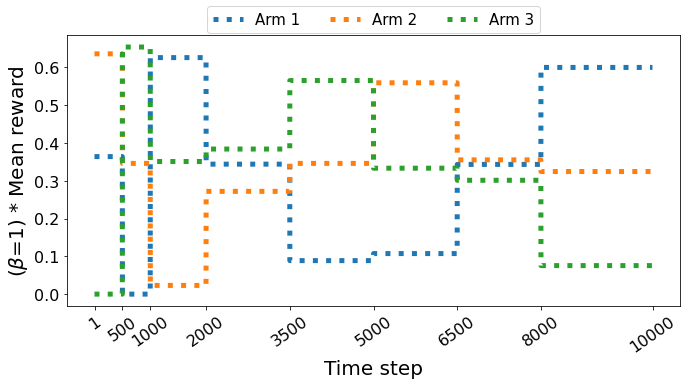

In [16]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = change_point_values
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})


plt.show()


In [17]:
np.random.seed(42)

# Compute accuracy plot for Alg1

Chose several cost intervals. For each range of costs compute the accuracy plot (accuracy for l = number of observed features).

In [18]:
cost_intervals = [
    [0.03, 0.06],
    [0.05, 0.08],
    [0.07, 0.10],
    [0.09, 0.12],
]

### Generate costs for each cost interval

In [19]:
cost_change_points = [3000, 5000, 7000, 9000]
interval_count = len(cost_change_points) + 1

all_costs_vectors = []
for cost_means_range in cost_intervals:


    # Mean of gaussian distribution random in interval [0, 0.02] 
    interval_means = [
        np.random.uniform(
            cost_means_range[0], cost_means_range[1], size=(new_contexts.shape[1],)
        ) for i in range(interval_count)
    ]

    # Fixed std
    interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count


    costs_obj = costs.NonstationaryGaussianCosts(
            feature_vector_size=new_contexts.shape[1],
            change_points=cost_change_points,
            interval_means=interval_means,
            interval_stds=interval_stds,
            random_seed=42,
        )

    costs_vector = []
    for t in range(new_contexts.shape[0]):
        costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
        costs_vector.append(costs_at_t)

    costs_vector = np.stack(costs_vector)
    all_costs_vectors.append(costs_vector)

## Run evaluation for different costs_vectors

In [20]:
def get_accuracy(alg1_object):
    N_FEATURES = alg1_object.max_no_red_context
    l_counts = np.zeros(N_FEATURES+1)
    l_rewards = np.zeros(N_FEATURES+1)
    
    for observation, reward in zip(alg1_object.selected_context_SimOOS, alg1_object.collected_rewards_SimOOS):
        num_observed = np.count_nonzero(observation)
        for k in range(num_observed+1):
            l_counts[k] += 1
            l_rewards[k] += reward  
            
    return l_rewards / l_counts

In [21]:
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

In [22]:
accuracies = {}

for i, cost_interval in enumerate(cost_intervals):
    interval_costs_vector = all_costs_vectors[i]
    COSTS_RANGE_SIZE = cost_interval[1] - cost_interval[0]
    
    # Run evaluation (possibly with repetition)
    accuracies_to_average = np.zeros((NUM_REPETITIONS, new_contexts.shape[1]+1))
    for rep in range(NUM_REPETITIONS):
        p_alg1 = algorithms.Algorithm1(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta=BETA,
            delta=0.1,
            window_length=250,
            costs_range=COSTS_RANGE_SIZE,

        )

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_alg1 = evaluation.evaluate_on_synthetic_data(
                p_alg1,
                new_contexts[:NUM_OF_TRIALS],
                new_rewards[:NUM_OF_TRIALS],
                costs_vector[:NUM_OF_TRIALS],
                beta=BETA,
                stop_after=NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        
        accuracy = get_accuracy(p_alg1)  
        accuracies_to_average[rep, :] = accuracy

    mean_accuracy = np.mean(accuracies_to_average, axis=0)
    print(f"Average accuracy: {mean_accuracy}")
       
    accuracies[tuple(cost_interval)] = mean_accuracy

Round 0, time 2022-05-22 07:38:19.846413
Round 500, time 2022-05-22 07:38:32.527706
Round 1000, time 2022-05-22 07:38:45.457910
Round 1500, time 2022-05-22 07:38:58.257916
Round 2000, time 2022-05-22 07:39:11.092385
Round 2500, time 2022-05-22 07:39:23.855848
Round 3000, time 2022-05-22 07:39:36.619286
Round 3500, time 2022-05-22 07:39:49.433716
Round 4000, time 2022-05-22 07:40:02.193083
Round 4500, time 2022-05-22 07:40:14.850093
Round 5000, time 2022-05-22 07:40:27.585427
Round 5500, time 2022-05-22 07:40:40.310182
Round 6000, time 2022-05-22 07:40:53.069895
Round 6500, time 2022-05-22 07:41:05.758495
Round 7000, time 2022-05-22 07:41:18.486670
Round 7500, time 2022-05-22 07:41:31.301903
Round 8000, time 2022-05-22 07:41:44.016479
Round 8500, time 2022-05-22 07:41:56.775429
Round 9000, time 2022-05-22 07:42:09.461148
Round 9500, time 2022-05-22 07:42:22.238482
Algorithm1 (beta=1, delta=0.1, w=250)
Beta = 1
Total gain: 6188.278807022793
	Total reward: 7047.0
	Total cost: 858.72119297

Round 8500, time 2022-05-22 08:11:38.295271
Round 9000, time 2022-05-22 08:11:51.032038
Round 9500, time 2022-05-22 08:12:03.644275
Algorithm1 (beta=1, delta=0.1, w=250)
Beta = 1
Total gain: 6756.945563778283
	Total reward: 7827.0
	Total cost: 1070.0544362217236
Execution time: 4.2m
Took 254.77703714370728 seconds
Round 0, time 2022-05-22 08:12:16.379740
Round 500, time 2022-05-22 08:12:28.867531
Round 1000, time 2022-05-22 08:12:41.610935
Round 1500, time 2022-05-22 08:12:54.346489
Round 2000, time 2022-05-22 08:13:07.080917
Round 2500, time 2022-05-22 08:13:19.830142
Round 3000, time 2022-05-22 08:13:32.511515
Round 3500, time 2022-05-22 08:13:45.178325
Round 4000, time 2022-05-22 08:13:57.832551
Round 4500, time 2022-05-22 08:14:10.566903
Round 5000, time 2022-05-22 08:14:23.255669
Round 5500, time 2022-05-22 08:14:35.986339
Round 6000, time 2022-05-22 08:14:48.711896
Round 6500, time 2022-05-22 08:15:01.449824
Round 7000, time 2022-05-22 08:15:14.171547
Round 7500, time 2022-05-22 

Round 4000, time 2022-05-22 08:43:38.017210
Round 4500, time 2022-05-22 08:43:50.780464
Round 5000, time 2022-05-22 08:44:03.567232
Round 5500, time 2022-05-22 08:44:16.311470
Round 6000, time 2022-05-22 08:44:28.951731
Round 6500, time 2022-05-22 08:44:41.621959
Round 7000, time 2022-05-22 08:44:54.337597
Round 7500, time 2022-05-22 08:45:07.046212
Round 8000, time 2022-05-22 08:45:19.732379
Round 8500, time 2022-05-22 08:45:32.390688
Round 9000, time 2022-05-22 08:45:45.118666
Round 9500, time 2022-05-22 08:45:57.713843
Algorithm1 (beta=1, delta=0.1, w=250)
Beta = 1
Total gain: 6186.4724626929055
	Total reward: 7167.0
	Total cost: 980.5275373070956
Execution time: 4.2m
Took 254.0253369808197 seconds
Round 0, time 2022-05-22 08:46:10.386523
Round 500, time 2022-05-22 08:46:22.886314
Round 1000, time 2022-05-22 08:46:35.642514
Round 1500, time 2022-05-22 08:46:48.318812
Round 2000, time 2022-05-22 08:47:00.994180
Round 2500, time 2022-05-22 08:47:13.744036
Round 3000, time 2022-05-22 0

In [23]:
accuracies

{(0.03, 0.06): array([0.73162   , 0.76648932, 0.42435731, 0.24455829]),
 (0.05, 0.08): array([0.74476   , 0.78100104, 0.4893495 , 0.        ]),
 (0.07, 0.1): array([0.7679    , 0.80240775, 0.52798446, 0.1       ]),
 (0.09, 0.12): array([0.73086   , 0.76511324, 0.63410804, 0.14136947])}

## Save accuracies

In [24]:
with open('experiments/nursery/results/accuracies.pickle', 'wb') as f:
    pickle.dump(accuracies, f)

## Load accuracies

In [25]:
with open('experiments/nursery/results/accuracies.pickle', 'rb') as f:
    accuracies = pickle.load(f)

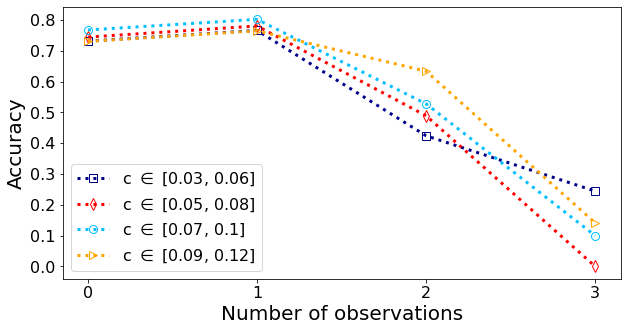

In [26]:
from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1, figsize=(10, 5))
ind_to_params = {
        # ind: (mark, color)
        0: ('s', 'darkblue'), 1: ('d','red'), 2: ('o','deepskyblue'), 3: ('>','orange'),
        4: ('^', 'm'), 5: ('<', 'k'), 6: ('x','green'),
    }

for ind, (cost_interval, accuracy_for_cost) in enumerate(accuracies.items()):
    mark, color = ind_to_params[ind]
    ax.plot(
        range(len(accuracy_for_cost)),
        accuracy_for_cost,
        label=fr"c $\in$ {list(cost_interval)}",
        marker=mark, markersize=8, fillstyle='none',
        c=color, linestyle=':', linewidth=3,
    )
    
ax.set_xlabel('Number of observations', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.xaxis.set_major_locator(MaxNLocator(integer=True)) # Only integer labels

plt.legend(prop={'size': 16});
plt.show()